With the folowing code we will obtain interaction matrices from the selected coordinates, normalise them, and filter out interactions involving non-captured loci (if still present and the capture folder has any coordiante). BAM files are not provided in the repository, but the resulting interaction matrices and subsequente analysis files are available

# Libraries and functions 

In [1]:
import sys
from pytadbit.parsers.hic_parser import load_hic_data_from_bam
import cPickle as pickle
from matplotlib import pyplot as plt
import os

# Parameters to modify 

Bamfiles should be stored in the bamfiles folder of a directory with the same files tree style as the one provided in this example. 

In [2]:
# Base path where the folder branch is stored
basePath = '/home/julen/TADdyn/TADdyn_tutorial/'

# Coordinates of the regions to normalise and convert into matrices.
# Bear in mind that if ending lies inside of a binned coordinate,
# the whole bin will be taken, like 8500000 in this example, that
# indicates the end of the coordinates and coincides with the 
# beginning of a bin, so the matrix will include data until
# 8500000 + resolution - 1 = 8504999
regions = {
    'b-globin':['chr11', 3795000, 8500000],
           }
resol = 5000

# Number of CPUs to use
ncpus = 16
# Path with capture locations used to filter out interactions in which these loci are
# not involved. If empty, or filtering already done before, you can store matrices from
# "matricesFreq" instead of the ones from "matricesFreqFlt" that will be stored in this 
# case
allPdir = basePath + 'additionaInput/baitCoord_hs38.txt'
# Format:
# chr	start	end
#1	912477	912596
#1	912790	912909

# Run

## Import additional libraries 

In [3]:
sys.path.append(basePath + 'code')
import fileHandling
import metrics
import plotting

## Define new paths

In [4]:
# Output path for pickles and plots
outdata = basePath + 'outData/inputData/'
outMatrix = basePath + 'matrices/'
outplot = basePath + 'outPlot/inputData/'

# create folders
! mkdir -p {outdata}
! mkdir -p {outplot}

## Get bamfile paths

In [5]:
files = fileHandling.bamPaths(basePath, ending='bam')

## Obtain normalisation biases

In [51]:
allConcatemers = {}
for cell in files:
    fi = files[cell]
    print(cell)

    allConcatemers[cell] = metrics.getInteractionsPerBin(fi, resol, filter_exclude=())
    
    # store it
    with open('%snormBiases_%s_%sbp.pickle' %(outdata, cell, resol), 'wb') as handle:
        pickle.dump(allConcatemers[cell], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Show in matrix 

In [10]:
matricesFreq = {}
matricesRaw = {}
matricesFreqFlt = {}
for reg in regions:
    matricesFreq[reg] = {}
    matricesRaw[reg] = {}
    matricesFreqFlt[reg] = {}
    
    print '#' * 10, reg, '#' * 10,

    for cell in files:
        fi = files[cell]
        
        matricesFreq[reg][cell] = {}
        matricesRaw[reg][cell] = {}
        matricesFreqFlt[reg][cell] = {}
        print '#' * 5, cell, '#' * 5,

        # get region parameters
        chrom = regions[reg][0]
        regionStart = regions[reg][1]
        regionEnd = regions[reg][2]
        print regionStart, regionEnd
        
        
        # load interaction object
        pchic_data = [1,2,3]
        del pchic_data
        pchic_data = load_hic_data_from_bam(fi, resol, region=chrom)
        startBin = pchic_data.section_pos[chrom][0] + (regionStart / resol)
        endBin = pchic_data.section_pos[chrom][0] + (regionEnd / resol)
        regRange = range(startBin, endBin + 1)
        
        ## Normalise
        hicSections = metrics.getSectionPos(fi, resol)
        norm_data = metrics.frequenciesNorm(pchic_data, resol, regRange, allConcatemers[cell],
                                   positionAdjust = hicSections[chrom][0])

        # here We load the raw interaction matrix 
        matrixRaw = pchic_data.get_matrix(focus = (startBin + 1, endBin + 1), normalized=False)
        # here the normalised one
        matrixFreq = norm_data.get_matrix(focus = (startBin + 1, endBin + 1), normalized=False)

        ## prepare non promoter filtering
        # Get capture position 
        # In the capture file chromosomes have no "chr" so we send chrom[3:]
        promList = metrics.getCaptures(allPdir, chrom[3:], regionStart, regionEnd, resol,
                       mlength=len(matrixRaw))
        

        # Remove from normalised matrix bins not containing a promoter
        matrixFreqFlt = [[0 for i in range(len(matrixFreq))] for i in range(len(matrixFreq))]
        for i in range(len(matrixFreq)):
            for j in promList:
                matrixFreqFlt[i][j] = matrixFreq[i][j]
                matrixFreqFlt[j][i] = matrixFreq[j][i]

        # store in variable
        matricesRaw[reg][cell] = matrixRaw
        matricesFreq[reg][cell] = matrixFreq
        matricesFreqFlt[reg][cell] = matrixFreqFlt

########## b-globin ########## ##### nCD4 ##### 3795000 8500000

  (Matrix size 27018x27018)                                                    [2020-11-18 20:13:01]

  - Parsing BAM (101 chunks)                                                   [2020-11-18 20:13:01]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101

  - Getting matrices                                                           [2020-11-18 20:14:46]
     .......... .......... .......... .......... ..........     50/101
     .......... .......... .......... .......... ..........    100/101
     .                                                         101/101

##### Ery ##### 3795000 8500000

  (Matrix size 27018x27018)                                                    [2020-11-18 20:17:24]

  - Parsing BAM (101 chunks)                                        

## Show normalised but not filtered matrices 

##### b-globin #####

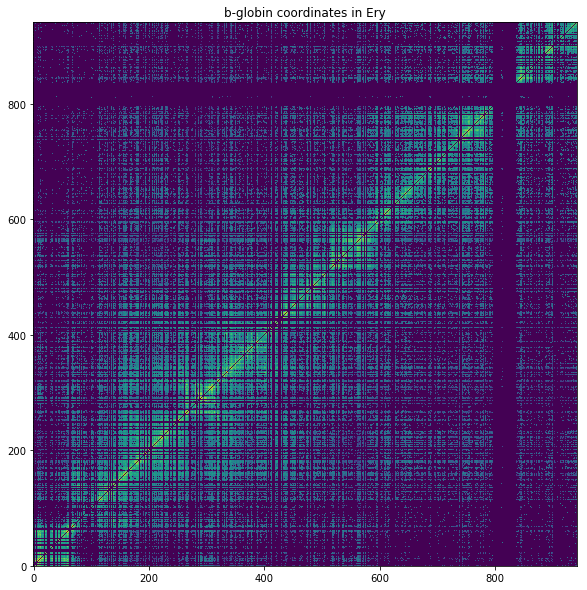

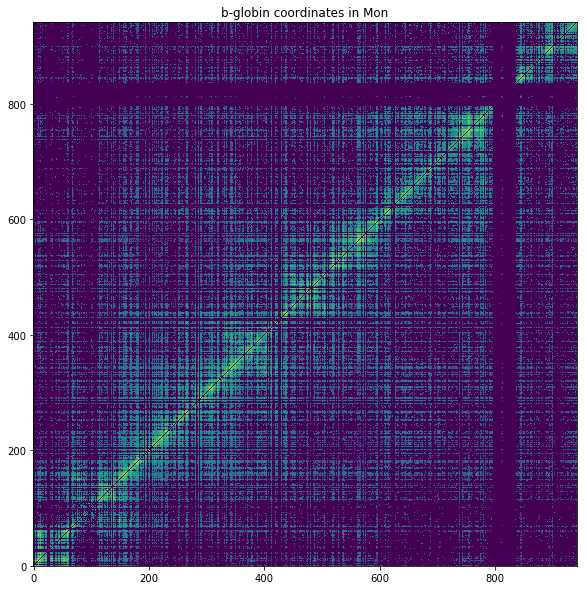

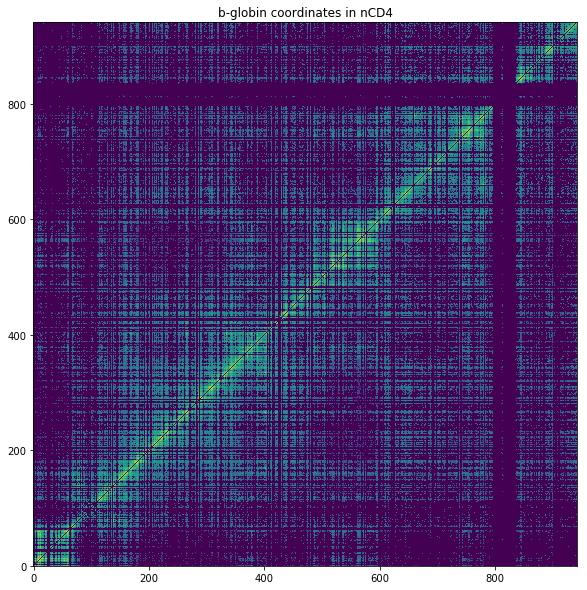

In [11]:
for reg in regions:
    print '#' * 5, reg, '#' * 5,
    for id1 in sorted(matricesFreq[reg]):
        matrix = matricesFreq[reg][id1]
        title = '%s coordinates in %s' %(reg, id1)
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        plotting.plotHiC(matrix, title=title, axe=ax)
        plt.show()


## Show normalised and filtered matrices 

##### b-globin #####

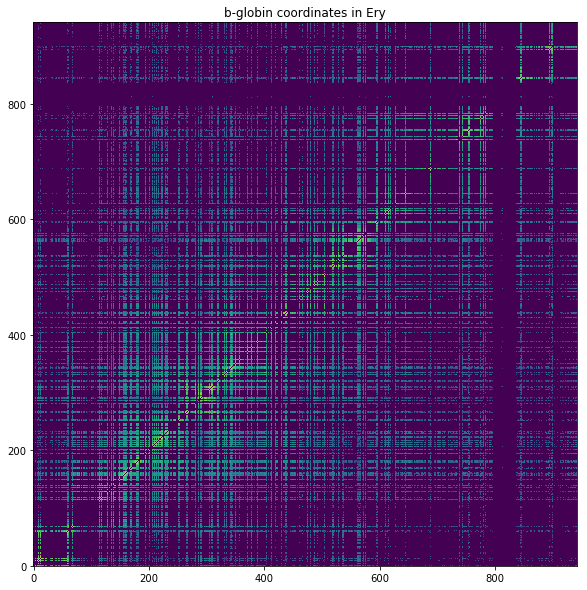

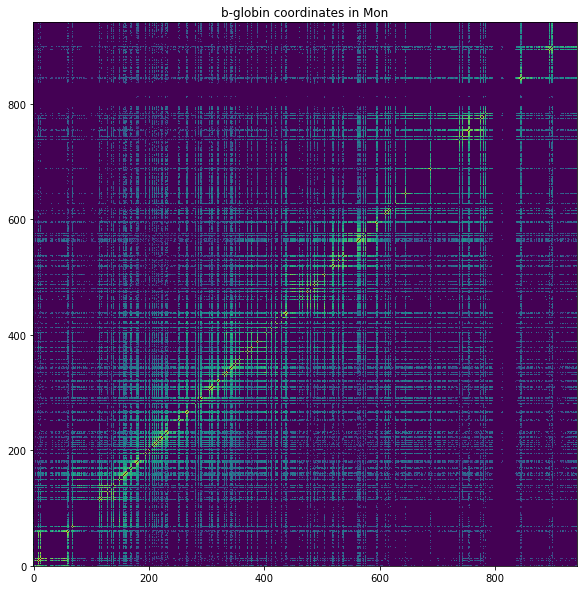

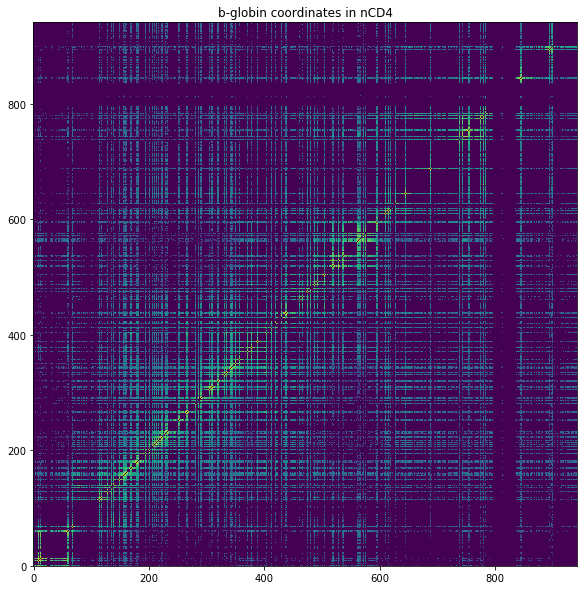

In [12]:
for reg in regions:
    print '#' * 5, reg, '#' * 5,
    for id1 in sorted(matricesFreqFlt[reg]):
        matrix = matricesFreqFlt[reg][id1]
        title = '%s coordinates in %s' %(reg, id1)
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        plotting.plotHiC(matrix, title=title, axe=ax)
        plt.show()


# Store normalised and filtered matrices 

In [15]:
for reg in regions:
    print '#' * 5, reg, '#' * 5,
    regionStart = regions[reg][1]
    regionEnd = regions[reg][2]
    chrom = regions[reg][0]
    for cell in sorted(matricesFreqFlt[reg]):
        matrix = matricesFreqFlt[reg][cell]
        # Store matrix as text
        outpath1 = outMatrix + '%s/%s/' %(cell, reg)
        if not os.path.exists(outpath1):
            os.makedirs(outpath1)
    
        matrix_end=open(outpath1  + "MatrixNormFreqFiltrd_%s_%s_%s-%s-%s_%sbp" %(cell, reg, chrom, regionStart, regionEnd, resol),'w')
        matrix_end.write('\n'.join(['\t'.join([str(cell) for cell in line]) for line in matrix]) + '\n')
        matrix_end.close()

##### b-globin #####
